# Get the genes overlapping the important tokens for SAUR

In [1]:
import pandas as pd


pd.set_option("display.max_columns", None) # show all cols
pd.set_option('display.max_colwidth', None) # show full width of showing cols
pd.set_option("display.expand_frame_repr", False) # print cols side by side as it's supposed to be

## Read bed files containing tokens

In [2]:
import os
import pandas as pd
from pathlib import Path


bedDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'bed_files', 'SAUR')

bedDfList = []
for bedFile in os.listdir(bedDir):
    tubeid = bedFile.split('.')[0].split('_')[0]
    tokensDf = pd.read_csv(Path(bedDir, bedFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score'])
    tokensDf['tube_id'] = tubeid
    bedDfList.append(tokensDf)

bedDf = pd.concat(bedDfList, ignore_index=True)
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id
0,1,0,6,TTTTCTT,0.000064,ALF22G140
1,1,7,9,ACC,-0.000395,ALF22G140
2,1,10,13,GACA,0.001573,ALF22G140
3,1,14,18,AGAAT,-0.000986,ALF22G140
4,1,19,25,TAATTAT,0.000795,ALF22G140
...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044
176721939,5,181674,181676,GCA,-0.003468,AH21C044
176721940,5,181677,181680,TCCA,-0.000228,AH21C044


## Calculate token lengths

In [3]:
bedDf['token_length'] = bedDf.tokens.apply(lambda x: len(x))
bedDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
0,1,0,6,TTTTCTT,0.000064,ALF22G140,7
1,1,7,9,ACC,-0.000395,ALF22G140,3
2,1,10,13,GACA,0.001573,ALF22G140,4
3,1,14,18,AGAAT,-0.000986,ALF22G140,5
4,1,19,25,TAATTAT,0.000795,ALF22G140,7
...,...,...,...,...,...,...,...
176721937,5,181665,181667,CGG,-0.002273,AH21C044,3
176721938,5,181668,181673,CTCATC,-0.001735,AH21C044,6
176721939,5,181674,181676,GCA,-0.003468,AH21C044,3
176721940,5,181677,181680,TCCA,-0.000228,AH21C044,4


## Calculate counts of token lengths

In [4]:
tokenlengthCountDf = bedDf.token_length.value_counts().reset_index().sort_values(by=['token_length'], ascending=True)
tokenlengthCountDf

,token_length,count
8,1,369058
6,2,3503389
4,3,10246519
3,4,18476852
0,5,54107814
1,6,49067795
2,7,31028269
5,8,8209701
7,9,1528839
9,10,167582


## Plot counts of token lengths

<Axes: xlabel='token_length', ylabel='count'>

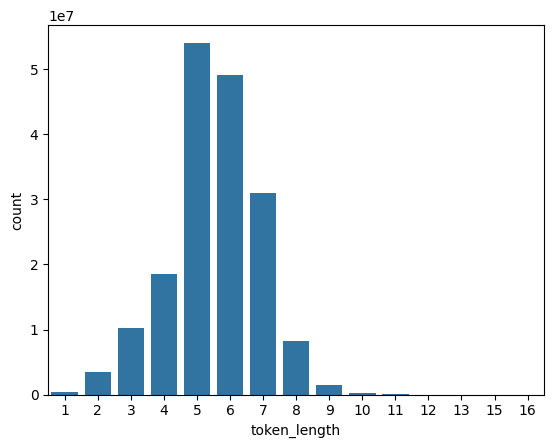

In [5]:
import seaborn as sns

sns.barplot(tokenlengthCountDf, x='token_length', y='count')

## Remove smaller tokens from this analysis

In [6]:
tokensDf = bedDf[bedDf.token_length > 10]
tokensDf

,contig_id,start_position,end_position,tokens,score,tube_id,token_length
12590,1,69263,69273,TATATATATAT,0.000834,ALF22G140,11
61062,1,334856,334866,CTCACTGCAAC,0.002666,ALF22G140,11
66837,1,366582,366592,AAATAAATAAA,-0.002220,ALF22G140,11
75592,2,21195,21205,AAATAAATAAA,-0.001987,ALF22G140,11
83222,2,63338,63350,TTTTTGTATTTTT,0.000883,ALF22G140,13
...,...,...,...,...,...,...,...
176686286,4,266803,266813,AAATAAATAAA,-0.001279,AH21C044,11
176686870,4,270015,270025,TTCTTTTCTTT,-0.001087,AH21C044,11
176703957,5,81915,81925,AAATAAATAAA,0.002236,AH21C044,11
176712559,5,129547,129557,AAAGAAAGAAA,0.000311,AH21C044,11


## Plot attribution score distribution

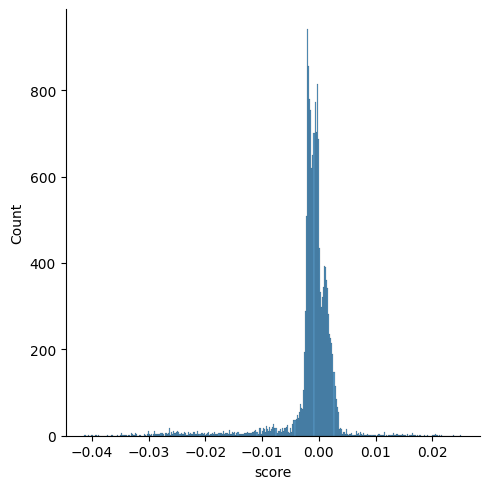

In [7]:
import seaborn as sns


sns.displot(tokensDf.score)

## Plot attribution score distribution (Zoomed)

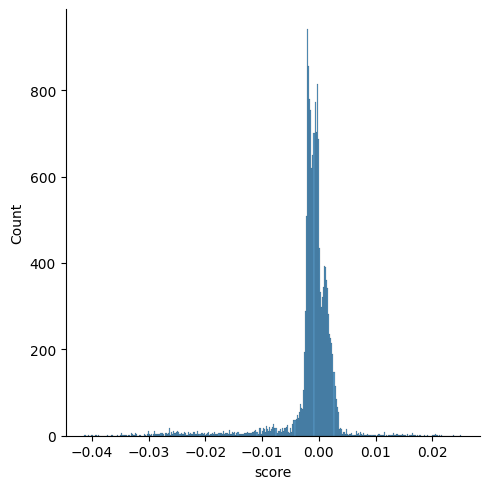

In [8]:
import seaborn as sns


sns.displot(tokensDf[(tokensDf.score > -0.05) & (tokensDf.score < 0.05)].score)

## Calculate high-score cut-off such that ~10 top tokens are selected

In [9]:
highscoreCutoff = tokensDf.score.mean() + 0.9 * tokensDf.score.std()
highscoreCutoff

np.float64(0.0031044564460859115)

## Obtain the number of tokens whose attribution score is over the cut-off

In [10]:
highscoreTokens = tokensDf[(tokensDf.score > highscoreCutoff)].tokens.unique()
len(highscoreTokens)

10

## Display the top tokens whose attribution score is over the cut-off

In [11]:
highscoreTokens

array(['AAATAAATAAA', 'TTTTTGTATTTTT', 'TATATATATAT', 'GGATATTTGGA',
       'TAATTTTTTGTATTTT', 'AAAAATACAAAAA', 'GGGATTATAGG', 'CTCACTGCAAC',
       'ATATATATATATATAT', 'GCTGCAGTGAG'], dtype=object)

## Read token overlaps with annotations

In [12]:
import os
import pandas as pd
from pathlib import Path


overlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'SAUR')

overlappingDfList = []
for overlappingFile in os.listdir(overlappingFilesDir):
    df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df['tube_code'] = [overlappingFile.split('_')[0]]*df.shape[0]
    overlappingDfList.append(df)
overlappingDf = pd.concat(overlappingDfList, ignore_index=True)
overlappingDf


/tmp/ipykernel_9533/3874131278.py:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
/tmp/ipykernel_9533/3874131278.py:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
/tmp/ipykernel_9533/3874131278.py:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atrib

,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,1,127,130,AAAA,-0.004951,CDS,OILJNO_00005,acyl carrier protein,acpP,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
1,1,131,134,TTTC,-0.000510,CDS,OILJNO_00005,acyl carrier protein,acpP,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
2,1,135,137,GAT,-0.009607,CDS,OILJNO_00005,acyl carrier protein,acpP,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
3,1,138,145,AAAGTAAA,0.009005,CDS,OILJNO_00005,acyl carrier protein,acpP,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
4,1,146,151,AGATAT,-0.010377,CDS,OILJNO_00005,acyl carrier protein,acpP,"ID=OILJNO_00005;Name=acyl carrier protein;locus_tag=OILJNO_00005;product=acyl carrier protein;Dbxref=GO:0000036,GO:0005737,GO:0046677,RefSeq:WP_000426914.1,SO:0001217,UniParc:UPI0000125385,UniRef:UniRef100_A7X1J8,UniRef:UniRef50_A7X1J8,UniRef:UniRef90_A7X1J8;gene=acpP",AH20I016
...,...,...,...,...,...,...,...,...,...,...,...
136910729,5,205776,205781,ATTTTT,-0.002056,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulO,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
136910730,5,205782,205787,AGGAGG,0.000008,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulO,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
136910731,5,205788,205790,CGT,-0.002779,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulO,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRef50_A0A0D1JKS9,UniRef:UniRef90_A0A0D1JKS9;gene=pulO",AH21K020
136910732,5,205791,205798,ATATTTTT,-0.000752,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase,pulO,"ID=KKIOAG_10525;Name=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;locus_tag=KKIOAG_10525;product=Prepilin signal peptidase PulO (type II secretory pathway) or related peptidase;Dbxref=COG:COG1989,COG:NU,RefSeq:WP_000261111.1,SO:0001217,UniParc:UPI0001DDA595,UniRef:UniRef100_A0A0D1JKS9,UniRef:UniRe

## Get annotation overlaps for high score tokens (signature)

In [13]:
import pandas as pd


tokenOverlapsDfs = []
for highscoreToken in highscoreTokens:
    tokenOverlapsDf = overlappingDf[overlappingDf.tokens == highscoreToken]
    tokenOverlapsDfs.append(tokenOverlapsDf)
finalTokenOverlapsDf = pd.concat(tokenOverlapsDfs, ignore_index=True)
finalTokenOverlapsDf

,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code
0,2,200640,200650,AAATAAATAAA,-0.001919,CDS,OILJNO_03395,staphyloferrin B biosynthesis decarboxylase SbnH,sbnH,"ID=OILJNO_03395;Name=staphyloferrin B biosynthesis decarboxylase SbnH;locus_tag=OILJNO_03395;product=staphyloferrin B biosynthesis decarboxylase SbnH;Dbxref=BlastRules:WP_001223700,COG:COG0019,COG:E,EC:4.1.1.117,GO:0006596,GO:0008836,GO:0009089,GO:0016831,GO:0019290,RefSeq:WP_001223709.1,SO:0001217,UniParc:UPI0001AE852E,UniRef:UniRef100_A0A6B5KYC0,UniRef:UniRef50_Q2G1M6,UniRef:UniRef90_Q2G1M6;gene=sbnH",AH20I016
1,2,330066,330076,AAATAAATAAA,0.002758,CDS,OILJNO_04000,polysaccharide intercellular adhesin biosynthesis/export protein IcaC,icaC,"ID=OILJNO_04000;Name=polysaccharide intercellular adhesin biosynthesis/export protein IcaC;locus_tag=OILJNO_04000;product=polysaccharide intercellular adhesin biosynthesis/export protein IcaC;Dbxref=BlastRules:WP_000723836,BlastRules:WP_002470903,COG:COG3936,COG:G,GO:0005886,GO:0016747,NCBIProtein:AUU58561.1,RefSeq:WP_000723836.1,SO:0001217,UniParc:UPI0000054957,UniRef:UniRef100_Q9RQP6,UniRef:UniRef50_Q9RQP6,UniRef:UniRef90_Q9RQP6;gene=icaC",AH20I016
2,3,243662,243672,AAATAAATAAA,-0.001922,CDS,OILJNO_06145,DUF420 domain-containing protein,yozB,"ID=OILJNO_06145;Name=DUF420 domain-containing protein;locus_tag=OILJNO_06145;product=DUF420 domain-containing protein;Dbxref=COG:COG2322,COG:R,KEGG:K08976,RefSeq:WP_000538766.1,SO:0001217,UniParc:UPI00000D787A,UniRef:UniRef100_W8URL7,UniRef:UniRef50_I3DYX6,UniRef:UniRef90_A0A0E1VIH3;gene=yozB",AH20I016
3,3,258364,258374,AAATAAATAAA,-0.001202,CDS,OILJNO_06230,NPQTN specific sortase B,srtB,"ID=OILJNO_06230;Name=NPQTN specific sortase B;locus_tag=OILJNO_06230;product=NPQTN specific sortase B;Dbxref=COG:COG4509,COG:S,EC:3.4.22.71,GO:0005886,GO:0016787,RefSeq:WP_001242410.1,SO:0001217,UniParc:UPI0002BC2BF7,UniRef:UniRef100_UPI0002BC2BF7,UniRef:UniRef50_Q2FZE3,UniRef:UniRef90_Q2FZE3,VFDB:VFC0272,VFDB:VFG044269;gene=srtB",AH20I016
4,4,67061,67071,AAATAAATAAA,-0.002060,CDS,OILJNO_07165,Tetratricopeptide repeat protein,NaN,"ID=OILJNO_07165;Name=Tetratricopeptide repeat protein;locus_tag=OILJNO_07165;product=Tetratricopeptide repeat protein;Dbxref=RefSeq:WP_000057543.1,SO:0001217,UniParc:UPI00000D768F,UniRef:UniRef100_A0A389NUI4,UniRef:UniRef50_Q49VW1,UniRef:UniRef90_A0A8D9YTG6",AH20I016
...,...,...,...,...,...,...,...,...,...,...,...
6989,3,292911,292921,GCTGCAGTGAG,-0.000490,CDS,NPJHNI_06590,urea transporter,yut,"ID=NPJHNI_06590;Name=urea transporter;locus_tag=NPJHNI_06590;product=urea transporter;Dbxref=COG:COG4413,COG:E,RefSeq:WP_000691095.1,SO:0001217,UniParc:UPI00004B5C9E,UniRef:UniRef100_X5DZB1,UniRef:UniRef50_A0A0M2NT05,UniRef:UniRef90_A0A0U1MRM9;gene=yut",AH21L032
6990,4,220717,220727,GCTGCAGTGAG,-0.001404,CDS,MHEJCN_08760,urea transporter,yut,"ID=MHEJCN_08760;Name=urea transporter;locus_tag=MHEJCN_08760;product=urea transporter;Dbxref=COG:COG4413,COG:E,SO:0001217,UniRef:UniRef50_A0A0M2NT05,UniRef:UniRef90_A0A0U1MRM9;gene=yut",AH21L011
6991,2,734390,734400,GCTGCAGTGAG,-0.001458,CDS,HKPDLO_07780,urea transporter,yut,"ID=HKPDLO_07780;Name=urea transporter;locus_tag=HKPDLO_07780;product=urea transporter;Dbxref=COG:COG4413,COG:E,RefSeq:WP_000691095.1,SO:0001217,UniParc:UPI00004B5C9E,UniRef:UniRef100_X5DZB1,UniRef:UniRef50_A0A0M2NT05,UniRef:UniRef90_A0A0U1MRM9;gene=yut",AH21A007
6992,3,195874,195884,GCTGCAGTGAG,-0.001283,CDS,FABJNC_05005,urea transporter,yut,"ID=FABJNC_05005;Name=urea transporter;locus_tag=FABJNC_05005;product=urea transporter;Dbxref=COG:COG4413,COG:E,RefSeq:WP_000691094.1,SO:0001217,UniParc:UPI00021AE1DA,UniRef:UniRef100_UPI00021AE1DA,UniRef:UniRef50_A0A0M2NT05,UniRef:UniRef90_A0A0U1MRM9;gene=yut",AH21K072


## Explore annotation overlaps for high score tokens (signature)

In [14]:
overlapCountsDf = finalTokenOverlapsDf.groupby(by=['tokens', 'name', 'feature_type']).agg({'contig_id': 'count'}).reset_index().sort_values(by='contig_id', ascending=False)
overlapCountsDf

,tokens,name,feature_type,contig_id
74,AAATAAATAAA,bifunctional lysylphosphatidylglycerol flippase/synthetase MprF,CDS,351
42,AAATAAATAAA,Glyoxylase or a related metal-dependent hydrolase%2C beta-lactamase superfamily II,CDS,246
75,AAATAAATAAA,branched-chain amino acid transport system II carrier protein,CDS,233
101,GGATATTTGGA,NADP-dependent isocitrate dehydrogenase,CDS,229
98,CTCACTGCAAC,type 8 capsular polysaccharide synthesis protein Cap8D,CDS,214
...,...,...,...,...
122,TATATATATAT,S. aureus Teg23 small RNA,ncRNA,1
134,TTTTTGTATTTTT,ATPase-AAA-core domain-containing protein,CDS,1
136,TTTTTGTATTTTT,Dehydrosqualene desaturase (Diapophytoene desaturase) (4%2C4-diapophytoene desaturase),CDS,1
142,TTTTTGTATTTTT,Staphylococcal tandem lipoprotein,CDS,1


## Save annotation overlaps for high score tokens (signature)

In [15]:
import os

from pathlib import Path


overlapCountsDf.to_csv(Path(os.environ['GENOMICS_DATA_BASE'], 'survival_analysis', 'SAUR', 'annotation_overlap_counts.csv'), index=False)